# Cooling Tower Identification: MODA Analysis

#### Import dependencies

* This was written in Python 2.7

In [1]:
import sys as sys
import os
import warnings

import pandas as pd
import numpy as np

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    from patsy import dmatrices
    from sklearn.linear_model import LogisticRegression;
    from sklearn.cross_validation import train_test_split;
    from sklearn import metrics


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('seaborn-notebook')
%matplotlib inline



np.random.seed(100)

/home/srimmele/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data_path = "../data/tower_data.csv"

if os.path.isfile(data_path):
    tower_data = pd.read_csv(data_path)
else:
    print 'run Tower-Identification-OSA-Data notebook first'

/home/srimmele/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7,8,9,11,28,51,53,54,78,80,84,92) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
###Some helper functions

def Remove_Dummy_BINS(df):
    '''
    removes illegitimate BINs from input dataframe.
    '''
    dummy_BINs = [1000000 , 2000000, 3000000, 4000000, 5000000]
    df = df[~df.BIN.isin(dummy_BINs)]
    return df


def CleanInputData(df):
    '''
    Performs cleaning on input tower_data, see comments below
    '''
    exclude_BC = ['A','B','V']                      # Removing single-family, 2-family, vacant land
    testset    = df[~df['BC'].isin(exclude_BC)]    
    testset    = testset[testset.BldgArea != 0]     # removing any buildings with no reported area
    testset    = testset[testset.NumFloors != 0]    # removing any buildings with no report floors
    return testset

## Exploratory Analysis

There are so many potentially relevant characteristics available in PLUTO. One very relevant factor is a building's class, which can indicate a lot about what's inside a building (and what needs to be kept cool).


Building Class Codes can be found in the appendix of the [PLUTO Data Dictionary](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwiNgdrMp-nWAhUFOiYKHYWoACMQFggoMAA&url=https%3A%2F%2Fwww1.nyc.gov%2Fassets%2Fplanning%2Fdownload%2Fpdf%2Fdata-maps%2Fopen-data%2Fpluto_datadictionary.pdf%3Fr%3D16v2&usg=AOvVaw1-CEPaXRsh0VS-bz9UKkb9)

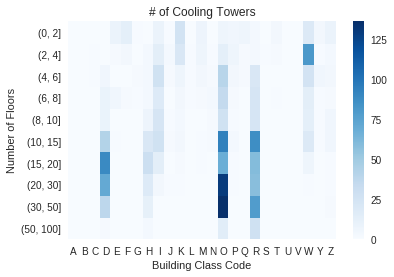

In [4]:
floor_bin = np.concatenate((np.arange(0,11,2) , [15,20,30,50,100]), axis=0)

tower_data['FLOOR_BIN'] = pd.cut(tower_data.NumFloors,floor_bin)

pivot = tower_data.pivot_table(index='FLOOR_BIN',columns='BC',values='Identified',aggfunc='sum')

hmap = sns.heatmap(pivot.fillna(0), cmap="Blues");

hmap.set(xlabel='Building Class Code', ylabel='Number of Floors', alpha=0.8, title = '# of Cooling Towers');


## More Data Preparation


In [5]:
## Cleaning the input data before running any models. We don't want to include people's homes who would not have
## commercial cooling units. 

testset = CleanInputData(tower_data)
print len(testset)

246335


#### Specify a model

It it tempting to include every available variable, but this can lead to a model that fits the training data extremely well but does not generalize.

In [6]:
# Lots of variables available, Adding too many leads to overfitting.

## Numerical Variables
I_Vars = [ 'Log_BldgArea', 'NumFloors', 'OfficeArea' , 'RetailArea', 'ComArea'] #,'LotArea','ComArea','ResArea','OfficeArea','RetailArea',\
          #'GarageArea','StrgeArea','FactryArea','OtherArea', 'OtherArea','NumBldgs',\
          #'UnitsRes','UnitsTotal','LotFront','BldgFront','LotDepth','BldgDepth','AssessLand',\
          #'ExemptLand','YearBuilt','BuiltFAR','ResidFAR','FacilFAR','CommFAR']

## Categorial Variables
C_Vars = ['BC', 'BoroCode']#,'LotType','BsmtCode'

C_Vars_format = [ 'C('+ c + ')' for c in C_Vars  ]

s = ' + '

Deps = s.join(I_Vars)
Cats = s.join(C_Vars_format)

Spec = 'Identified ~ ' + Deps + ' + ' + Cats
Spec_I = 'Identified ~ ' + Deps 
Spec_C = 'Identified ~ ' + Cats 


print Spec # this is the model string for logistic regression


print len(testset)

## Dropping records that aren't valid for the variables in question
testset.dropna(subset=C_Vars, inplace=True)
testset.dropna(subset=I_Vars, inplace=True)

print len(testset) # appears to be only one 


for c in C_Vars:
    testset[[c]] = testset[c].astype(str)

Identified ~ Log_BldgArea + NumFloors + OfficeArea + RetailArea + ComArea + C(BC) + C(BoroCode)
246335
246334


### Splitting into training and testing data (30% testing)

In [7]:
y, X = dmatrices(Spec,testset,return_type="dataframe")

y = np.ravel(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)



## choice to normalize variables if wanted, makes a difference with the SVM classifier
normed = X_train[I_Vars] 
normed = (normed - normed.mean()) / normed.std()
X_train.update(normed)

normed = X_test[I_Vars] 
normed = (normed - normed.mean()) / normed.std()
X_test.update(normed)



/home/srimmele/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:3863: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  raise_on_error=True)


## Testing a simple logistic regression with varying regularization




In [8]:
for c in np.arange(-5,5):
    
    model =   LogisticRegression(C=10.0**c, penalty='l2')
    model.fit(X_train, y_train)
    
    predicted = model.predict(X_test)
    print '(inverse) regularization: ' + str(10.0**c)
    
    print metrics.classification_report(y_test,predicted )
    probs = model.predict_proba(X_test)
    
    print '\n score: ' + str(metrics.roc_auc_score(y_test, probs[:, 1]))


(inverse) regularization: 1e-05
             precision    recall  f1-score   support

        0.0       0.99      1.00      1.00     73355
        1.0       0.82      0.14      0.24       546

avg / total       0.99      0.99      0.99     73901


 score: 0.959589649212
(inverse) regularization: 0.0001
             precision    recall  f1-score   support

        0.0       0.99      1.00      1.00     73355
        1.0       0.79      0.20      0.32       546

avg / total       0.99      0.99      0.99     73901


 score: 0.969697651768
(inverse) regularization: 0.001
             precision    recall  f1-score   support

        0.0       0.99      1.00      1.00     73355
        1.0       0.73      0.26      0.38       546

avg / total       0.99      0.99      0.99     73901


 score: 0.983183976862
(inverse) regularization: 0.01
             precision    recall  f1-score   support

        0.0       0.99      1.00      1.00     73355
        1.0       0.71      0.30      0.42      

In [9]:
def ModelSummary(y_test, predicted):

    TP = float(metrics.confusion_matrix(y_test, predicted)[1][1] ) # true positive
    FP = float(metrics.confusion_matrix(y_test, predicted)[0][1] ) # false positive
    FN = float(metrics.confusion_matrix(y_test, predicted)[1][0] ) # false negative
    TN = float(metrics.confusion_matrix(y_test, predicted)[0][0] ) # true negative

    print 'Recall %.3f' % (TP/(TP+FN))
    print 'Precision %.3f' % (TP/(TP+FP))
    print '%.3f of buildings sampled have towers' % (sum(y)/len(y))


### Results

* We are identifying on the order of 30% of true towers in the testing set, not ideal
* But, 65-70% of our predicted towers are true towers, not bad when compared to picking randomly (< 1%)


In [10]:
ModelSummary(y_test, predicted)

Recall 0.366
Precision 0.669
0.007 of buildings sampled have towers


### Another way of showing this with a ROC curve

Aiming for higher recall (y-axis) will dramatically increase the the false-positive-rate (x-axis). The false positive problem is particularly important in the cooling towers case, because the classes are so imbalanced - less than 1% of buildings are identified with a cooling tower. 

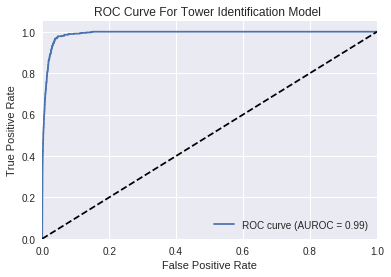

In [11]:
n_classes = 2

FPR = dict()
TPR = dict()

roc_auc = dict()
for i in range(n_classes):
    FPR[i], TPR[i], _ = metrics.roc_curve(y_test, probs[:, i])
    roc_auc[i] = metrics.auc(FPR[i], TPR[i])


    
plt.figure()
plt.plot(FPR[1], TPR[1], label='ROC curve (AUROC = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve For Tower Identification Model ')
plt.legend(loc="lower right")

plt.show()


## Another classifier: support vector machine 


In [12]:
from sklearn import svm

# Option to give more class-weight to identified cooling towers because they are very sparse in the dataset of total buildings.
ClassWeights = [1, 5, 10, 15, 20, 30] 


for weight in ClassWeights:
    svm_model = svm.LinearSVC(class_weight={1: weight, 0 : 1})
    svm_model.fit(X_train, y_train)
    predicted = svm_model.predict(X_test)
    print metrics.classification_report(y_test,predicted )

             precision    recall  f1-score   support

        0.0       0.99      1.00      1.00     73355
        1.0       0.76      0.27      0.40       546

avg / total       0.99      0.99      0.99     73901

             precision    recall  f1-score   support

        0.0       1.00      0.99      1.00     73355
        1.0       0.46      0.58      0.51       546

avg / total       0.99      0.99      0.99     73901

             precision    recall  f1-score   support

        0.0       1.00      0.99      0.99     73355
        1.0       0.33      0.72      0.46       546

avg / total       0.99      0.99      0.99     73901

             precision    recall  f1-score   support

        0.0       1.00      0.99      0.99     73355
        1.0       0.29      0.79      0.42       546

avg / total       0.99      0.98      0.99     73901

             precision    recall  f1-score   support

        0.0       1.00      0.98      0.99     73355
        1.0       0.25      0.85 

### Support Vector Classifier Results

* Much higher recall, finding nearly 90% of cooling towers
* We have to pay a price in precision for finding more towers, precision is only 23%
* Still much better than picking randomly
* Can tune class weights to dial-in the precision vs. recall we want



In [13]:
ModelSummary(y_test, predicted)

Recall 0.886
Precision 0.228
0.007 of buildings sampled have towers


# Postscript

One obvious conclusion is the trade-off between precision and recall, which amounts to asking oneself *"how many false positives am I willing to tolerate in order to find every true positive (cooling tower)."* The answer to this kind of question is more often than not dependant on a (non-technical) operational constraint, which could stem from many factors such as the resources available or relative priorities of competing goals. 

### Try it for yourself

These models are very basic and a reflection of time and resource constraints during the Legionnaires' disease activation. Playing with different types of models, cross-validation, hyperparameter tuning, etc. would surely produce an improved model. If you find one, let us know!

